In [210]:
# Cell 1: Imports & setup
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, top_k_accuracy_score
)
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
# Cell 2: Read data & basic config

folder_path = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/data_sync/outputs"

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "NR" in f]

dataframes = {}
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes[file] = df

# ==== CONFIG ====
TEST_FILE = "BIA24-3_NR_merged_with_gear.csv"  # one file as test set

input_cols = ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts']
output_cols = ["Gear"]

# LSTM sequence config
SEQ_LEN = 5   # <-- choose your sequence length here
STEP    = 1   # stride between sequence start positions

print("Loaded CSV files:")
for k in sorted(dataframes.keys()):
    print(" •", k)

_sample_key = next(iter(dataframes))
print("\nColumns in sample file:", _sample_key)
print(list(dataframes[_sample_key].columns))

print("\nUsing inputs:", input_cols)
print("Using output:", output_cols)
print("Test file:", TEST_FILE)
print("SEQ_LEN:", SEQ_LEN, "| STEP:", STEP)


Loaded CSV files:
 • BIA24-15_NR_merged_with_gear.csv
 • BIA24-16_NR_merged_with_gear.csv
 • BIA24-18_NR_merged_with_gear.csv
 • BIA24-19_NR_merged_with_gear.csv
 • BIA24-20_NR_merged_with_gear.csv
 • BIA24-22_NR_merged_with_gear.csv
 • BIA24-3_NR_merged_with_gear.csv
 • BIA24-4_NR_merged_with_gear.csv
 • BIA24-5_NR_merged_with_gear.csv
 • BIA24-7_NR_merged_with_gear.csv
 • BIA24-8_NR_merged_with_gear.csv
 • BIA24-9_NR_merged_with_gear.csv

Columns in sample file: BIA24-20_NR_merged_with_gear.csv
['sessionid', 'tt_s', 'distance_m', 'slope_pct', 'speed_kmph', 'power_w', 'heartrate_bpm', 'frequency_ppm', 'cycle', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'treadmill_force_n', 'altitude_m', 'latitude_deg', 'longitude_deg', 'usernote = BIA24-20NR', 'Variant', 'Sport', 'ns1:Id', 'StartTime', 'ns1:TotalTimeSeconds', 'ns1:DistanceMeters', 'ns1:MaximumSpeed', 'ns1:Calories', 'ns1:Value', 'ns1:Value2', 'ns1:Inten

In [212]:
# Cell 3: Data split (by file), Scaler, and LabelEncoder

# 1. Split keys into TRAIN, VAL, and TEST
all_keys = sorted([k for k in dataframes.keys() if k != TEST_FILE])

# Split files so Train and Val never share time windows (Fixes Data Leakage)
train_keys, val_keys = train_test_split(all_keys, test_size=0.2, random_state=42)
test_key = TEST_FILE

print(f"Files in Train: {len(train_keys)}")
print(f"Files in Val:   {len(val_keys)}")
print(f"Files in Test:  1 ({test_key})")

# 2. Concatenate for fitting Scaler/Encoder
# We fit on TRAIN only, but we need to know all possible labels to avoid errors
train_df_concat = pd.concat([dataframes[k] for k in train_keys], ignore_index=True)
val_df_concat = pd.concat([dataframes[k] for k in val_keys], ignore_index=True)
test_df = dataframes[test_key].copy()

# --- Normalization Helper ---
def normalize_gear(gear_str):
    gear_str = str(gear_str)
    match = re.search(r'(\d+\.?\d*)', gear_str)
    return match.group(1) if match else gear_str

label_col = output_cols[0]

# Apply Normalization
for df in [train_df_concat, val_df_concat, test_df]:
    df[label_col] = df[label_col].apply(normalize_gear)

# 3. Fit LabelEncoder (Fit on ALL known labels to be safe)
all_possible_labels = pd.concat([train_df_concat[label_col], val_df_concat[label_col], test_df[label_col]]).unique()
label_encoder = LabelEncoder()
label_encoder.fit(all_possible_labels)
num_classes = len(label_encoder.classes_)
print(f"\nClasses ({num_classes}): {label_encoder.classes_}")

# 4. Fit Scaler (Fit on TRAIN ONLY)
# We must filter NaNs before fitting scaler
train_df_concat = train_df_concat.dropna(subset=input_cols + output_cols)
scaler = StandardScaler()
scaler.fit(train_df_concat[input_cols].values.astype(np.float32))

print("Scaler and Encoder fitted successfully.")

Files in Train: 8
Files in Val:   3
Files in Test:  1 (BIA24-16_NR_merged_with_gear.csv)

Classes (4): ['0.0' '2.0' '3.0' '4.0']
Scaler and Encoder fitted successfully.


In [213]:
# Cell 3.5: Filter for Stable Gears (Remove transition windows)

# Define the number of samples (rows) to remove before AND after a gear switch.
# A value of X removes a total window of 2 * X + 1 around each switch.
TRANSITION_SAMPLES_TO_REMOVE = 4 # <--- Increased to 4 for better separation

label_col = output_cols[0]

def filter_unstable_gears(df: pd.DataFrame, label_col: str, window_size: int) -> pd.DataFrame:
    """Removes samples in a window around where the label (gear) changes."""
    if df.empty:
        return df

    # Find where the label changes (True for the first row of a new gear)
    gear_changes = df[label_col].ne(df[label_col].shift(1))
    change_points = df[gear_changes].index.tolist()
    
    remove_indices = set()
    
    # For each change point, mark the window around it for removal
    for idx in change_points:
        # The change occurs AT idx (idx starts the new gear)
        
        # Remove the samples BEFORE the switch (indices: idx-window_size to idx-1)
        for i in range(idx - window_size, idx):
            if i in df.index:
                remove_indices.add(i)
        
        # Remove the samples AT and AFTER the switch (indices: idx to idx + window_size - 1)
        for i in range(idx, idx + window_size):
            if i in df.index:
                remove_indices.add(i)
    
    # Now, filter the DataFrame
    original_size = len(df)
    filtered_df = df.drop(index=list(remove_indices), errors='ignore')
    
    # Only print if we actually removed something to avoid spam
    if original_size != len(filtered_df):
        print(f"Filter applied: Removed {original_size - len(filtered_df)} samples "
              f"(~{((original_size - len(filtered_df))/original_size)*100:.2f}%).")
    
    return filtered_df

print(f"--- Applying Transition Filter (Window size: {TRANSITION_SAMPLES_TO_REMOVE}) ---")

# 1. Apply to the full concat df (mostly for reference/sanity check)
train_df_full = filter_unstable_gears(train_df_full, label_col, TRANSITION_SAMPLES_TO_REMOVE)

# 2. CRITICAL FIX: Apply filter to the dictionary source for Cell 4
print("Filtering individual training files...")
for k in train_keys:
    dataframes[k] = filter_unstable_gears(dataframes[k], label_col, TRANSITION_SAMPLES_TO_REMOVE)

# 3. Apply to test df
test_df = filter_unstable_gears(test_df, label_col, TRANSITION_SAMPLES_TO_REMOVE)

print("-------------------------------------------------------------------------------------------------")

--- Applying Transition Filter (Window size: 4) ---
Filter applied: Removed 927 samples (~10.09%).
Filtering individual training files...
Filter applied: Removed 327 samples (~32.77%).
Filter applied: Removed 296 samples (~27.13%).
Filter applied: Removed 265 samples (~23.81%).
Filter applied: Removed 293 samples (~24.50%).
Filter applied: Removed 307 samples (~27.24%).
Filter applied: Removed 334 samples (~25.85%).
Filter applied: Removed 558 samples (~44.53%).
Filter applied: Removed 207 samples (~18.30%).
Filter applied: Removed 210 samples (~20.59%).
-------------------------------------------------------------------------------------------------


In [214]:
# Cell 4: Build sequences per file

def build_sequences_from_df(df, input_cols, label_col, seq_len, step, scaler, label_encoder):
    # 1. Clean data
    df = df.dropna(subset=input_cols + [label_col]).reset_index(drop=True)
    if len(df) < seq_len:
        return None, None

    # 2. Feature Processing
    X = df[input_cols].values.astype(np.float32)
    X_scaled = scaler.transform(X)
    
    # 3. Label Processing
    # (Normalization already done in Cell 3, but good to be safe)
    normalized_labels = df[label_col].astype(str).apply(normalize_gear)
    y_frames = label_encoder.transform(normalized_labels.values)

    X_seq_list = []
    y_seq_list = []

    # 4. Create Sequences (Many-to-One)
    n = len(df)
    for start in range(0, n - seq_len + 1, step):
        end = start + seq_len
        window_X = X_scaled[start:end]
        
        # Many-to-One: We take the label of the LAST frame in the sequence
        window_y = y_frames[end - 1] 
        
        X_seq_list.append(window_X)
        y_seq_list.append(window_y)

    if not X_seq_list:
        return None, None

    return np.stack(X_seq_list), np.array(y_seq_list, dtype=np.int64)

def create_dataset(keys_list, name):
    X_list, y_list = [], []
    for k in keys_list:
        df = dataframes[k].copy()
        X_seqs, y_seqs = build_sequences_from_df(df, input_cols, label_col, SEQ_LEN, STEP, scaler, label_encoder)
        if X_seqs is not None:
            X_list.append(X_seqs)
            y_list.append(y_seqs)
    
    if not X_list:
        raise ValueError(f"No data found for {name} set!")
        
    return np.concatenate(X_list, axis=0), np.concatenate(y_list, axis=0)

# Generate sets
print("Building Train sequences...")
X_train, y_train = create_dataset(train_keys, "Train")

print("Building Val sequences...")
X_val, y_val = create_dataset(val_keys, "Val")

print("Building Test sequences...")
X_test, y_test = build_sequences_from_df(test_df, input_cols, label_col, SEQ_LEN, STEP, scaler, label_encoder)

print(f"\nFinal Shapes:")
print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

Building Train sequences...
Building Val sequences...
Building Test sequences...

Final Shapes:
Train: (6582, 5, 14)
Val:   (3457, 5, 14)
Test:  (806, 5, 14)


In [215]:
# Cell 5: Calculate Class Weights

# We skip the "balancing" step of duplicating data because it causes overfitting.
# Instead, we calculate weights to give to the Loss Function.

class_counts = np.bincount(y_train)
total_samples = len(y_train)
num_classes = len(class_counts)

# Formula: Total / (Num_Classes * Count_of_Class)
# This gives higher weight to rare classes
weights_np = total_samples / (num_classes * class_counts)

# Convert to tensor
class_weights = torch.tensor(weights_np, dtype=torch.float32).to(device)

print("Class counts:", class_counts)
print("Class weights calculated:", class_weights)

# Prepare Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.long, device=device)

X_val_t = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val_t = torch.tensor(y_val, dtype=torch.long, device=device)

X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_t = torch.tensor(y_test, dtype=torch.long, device=device)

seq_len = X_train.shape[1]
input_dim = X_train.shape[2]

Class counts: [1223 1014 3855  490]
Class weights calculated: tensor([1.3455, 1.6228, 0.4268, 3.3582])


In [216]:
# Cell 6: Convert sequence data to PyTorch tensors

X_train_t = torch.tensor(X_train_bal, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train_bal, dtype=torch.long, device=device)

X_val_t = torch.tensor(X_val_seqs, dtype=torch.float32, device=device)
y_val_t = torch.tensor(y_val_seqs, dtype=torch.long, device=device)

X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_t = torch.tensor(y_test, dtype=torch.long, device=device)

seq_len = X_train_t.shape[1]
input_dim = X_train_t.shape[2]
output_dim = num_classes

print(f"Input dim: {input_dim} | Seq len: {seq_len} | Classes: {output_dim}")


Input dim: 14 | Seq len: 5 | Classes: 4


In [217]:
# Cell 7: LSTM model definition

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0)
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, (hn, cn) = self.lstm(x)
        
        # MANY-TO-ONE ARCHITECTURE:
        # We take the hidden state of the LAST timestep only.
        last_hidden = hn[-1]  # (batch, hidden_dim)
        
        last_hidden = self.dropout(last_hidden)
        logits = self.fc(last_hidden)  # (batch, num_classes)
        return logits

# Initialize Model
model = LSTMClassifier(
    input_dim=input_dim,
    hidden_dim=64,
    num_layers=2,         # 2 layers is often enough for simple sequence classification
    num_classes=num_classes,
    dropout=0.3
).to(device)

# CRITICAL: Pass the class_weights here!
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

print(model)
print("Loss function initialized with Class Weights.")

LSTMClassifier(
  (lstm): LSTM(14, 64, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)
Loss function initialized with Class Weights.


In [218]:
# Cell 8: Training loop

EPOCHS = 200
BATCH_SIZE = 128
PRINT_EVERY = 1

def batches(X, y, batch_size):
    n = X.shape[0]
    idx = torch.randperm(n, device=device)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch_idx = idx[start:end]
        yield X[batch_idx], y[batch_idx]

history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")

for epoch in range(1, EPOCHS + 1):
    # ---- Training phase ----
    model.train()
    running_loss = 0.0
    num_batches = 0

    for Xb, yb in batches(X_train_t, y_train_t, BATCH_SIZE):
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    avg_train_loss = running_loss / max(1, num_batches)
    history['train_loss'].append(avg_train_loss)

    # ---- Validation phase ----
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = criterion(val_logits, y_val_t).item()
        val_pred = val_logits.argmax(dim=1)
        val_correct = (val_pred == y_val_t).sum().item()
        val_acc = val_correct / len(y_val_t)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if epoch % PRINT_EVERY == 0:
        print(f"Epoch {epoch:03d} | "
              f"Train loss: {avg_train_loss:.4f} | "
              f"Val loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

print("Training finished.")


Starting training...
Epoch 001 | Train loss: 0.6267 | Val loss: 0.6596 | Val Acc: 0.5380
Epoch 002 | Train loss: 0.3336 | Val loss: 0.4939 | Val Acc: 0.6701
Epoch 003 | Train loss: 0.2682 | Val loss: 0.4661 | Val Acc: 0.6630
Epoch 004 | Train loss: 0.2320 | Val loss: 0.3902 | Val Acc: 0.7013
Epoch 005 | Train loss: 0.2025 | Val loss: 0.3478 | Val Acc: 0.7449
Epoch 006 | Train loss: 0.1832 | Val loss: 0.4083 | Val Acc: 0.7105
Epoch 007 | Train loss: 0.1638 | Val loss: 0.3367 | Val Acc: 0.7510
Epoch 008 | Train loss: 0.1553 | Val loss: 0.2822 | Val Acc: 0.8034
Epoch 009 | Train loss: 0.1454 | Val loss: 0.3017 | Val Acc: 0.7886
Epoch 010 | Train loss: 0.1317 | Val loss: 0.2753 | Val Acc: 0.8099
Epoch 011 | Train loss: 0.1190 | Val loss: 0.2369 | Val Acc: 0.8323
Epoch 012 | Train loss: 0.1148 | Val loss: 0.2536 | Val Acc: 0.8127
Epoch 013 | Train loss: 0.1058 | Val loss: 0.2431 | Val Acc: 0.8312
Epoch 014 | Train loss: 0.1006 | Val loss: 0.2323 | Val Acc: 0.8383
Epoch 015 | Train loss: 0.0

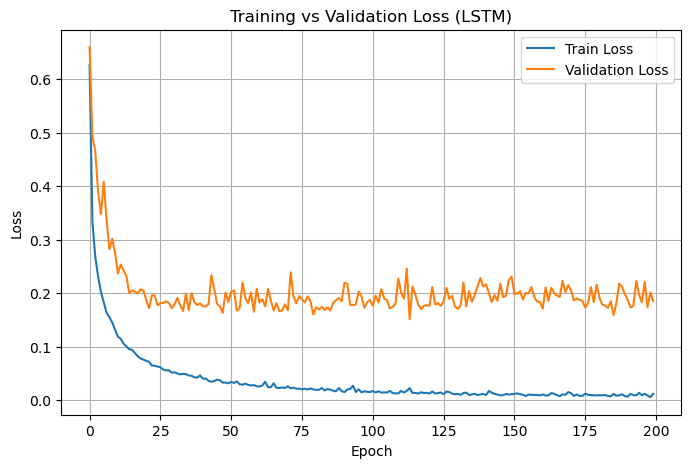

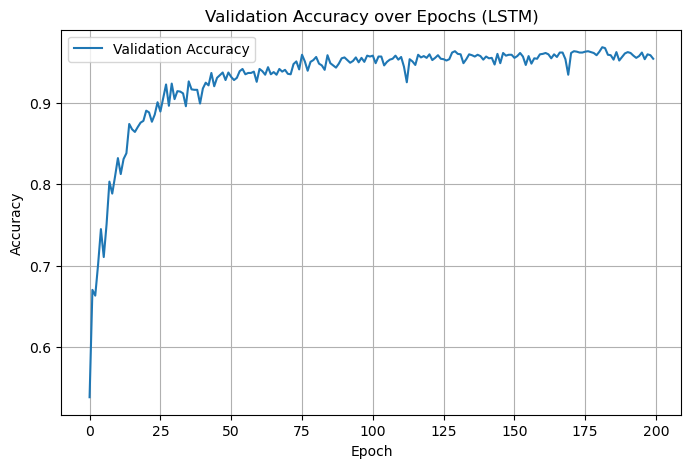

In [219]:
# Cell 9: Plot training vs validation loss

plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (LSTM)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs (LSTM)')
plt.legend()
plt.grid(True)
plt.show()


Test Accuracy: 0.9665
Test Top-3 Accuracy: 1.0000

Classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       104
         2.0       0.98      1.00      0.99       168
         3.0       0.99      0.96      0.97       534
         4.0       0.00      0.00      0.00         0

    accuracy                           0.97       806
   macro avg       0.73      0.73      0.73       806
weighted avg       0.99      0.97      0.98       806



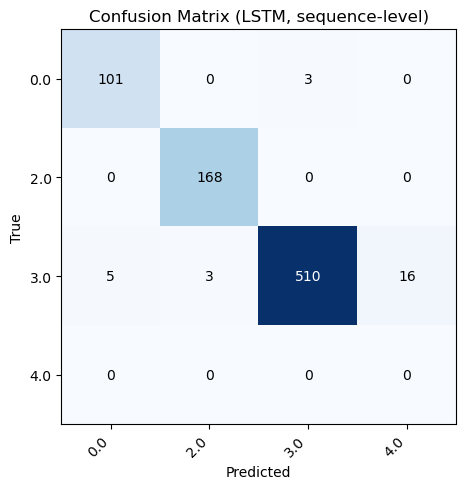

In [221]:
# Cell 10: Evaluate on TEST sequences

model.eval()
with torch.no_grad():
    test_logits = model(X_test_t)
    test_probs = torch.softmax(test_logits, dim=1).cpu().numpy()
    pred_labels = test_probs.argmax(axis=1)

y_true = y_test_t.cpu().numpy()

# 1. Standard Accuracy
acc = accuracy_score(y_true, pred_labels)

# 2. Fix for Top-k Error: Explicitly pass the list of all possible labels
# This prevents the error when the test set is missing one or more gears.
all_labels = np.arange(num_classes)  # [0, 1, 2, 3] if num_classes=4
top3 = top_k_accuracy_score(y_true, test_probs, k=min(3, num_classes), labels=all_labels)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Top-3 Accuracy: {top3:.4f}\n")

# 3. Classification Report
target_names = list(label_encoder.classes_)
print("Classification report:")
# Use labels=all_labels here too to force the report to show 0.0s for missing classes
print(classification_report(y_true, pred_labels, target_names=target_names, labels=all_labels, zero_division=0))

# 4. Confusion Matrix
cm = confusion_matrix(y_true, pred_labels, labels=all_labels)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) # Added colormap for better visibility
plt.title('Confusion Matrix (LSTM, sequence-level)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(target_names)), labels=target_names)

for (i, j), v in np.ndenumerate(cm):
    color = "white" if cm[i, j] > cm.max() / 2 else "black"
    plt.text(j, i, str(v), ha='center', va='center', color=color)

plt.tight_layout()
plt.show()